
#**PRODUCT PRICING PREDICTION USING HYBRID MACHINE LEARNING MODEL**






### **SECTION 1: SETUP AND IMPORTS**

In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ProductPricingPrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### **SECTION 2: DATA LOADING**

In [2]:
# Load training and test data
from pyspark.sql.functions import to_date

# Load the data
train_df = spark.read.csv("/content/train.csv", header=True, inferSchema=True)

# Convert 'Date' column to proper DateType
train_df = train_df.withColumn("Date", to_date("Date", "d/M/yyyy"))

# Same for test_df
test_df = spark.read.csv("/content/test.csv", header=True, inferSchema=True)
test_df = test_df.withColumn("Date", to_date("Date", "d/M/yyyy"))


# Show the schema and sample data
print("Training Data Schema:")
train_df.printSchema()
print("\nTraining Data Sample:")
train_df.show(13)

print("\nTest Data Schema:")
test_df.printSchema()
print("\nTest Data Sample:")
test_df.show(13)


Training Data Schema:
root
 |-- Product: string (nullable = true)
 |-- Product_Brand: string (nullable = true)
 |-- Item_Category: string (nullable = true)
 |-- Subcategory_1: string (nullable = true)
 |-- Subcategory_2: string (nullable = true)
 |-- Item_Rating: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Selling_Price: integer (nullable = true)


Training Data Sample:
+-------+-------------+--------------------+--------------------+--------------------+-----------+----------+-------------+
|Product|Product_Brand|       Item_Category|       Subcategory_1|       Subcategory_2|Item_Rating|      Date|Selling_Price|
+-------+-------------+--------------------+--------------------+--------------------+-----------+----------+-------------+
| P-8398|       B-3078|            footwear|    women s footwear|        casual shoes|        4.1|2017-04-12|         1798|
| P-9951|       B-2605|home decor festiv...|          showpieces|shoppingtara show...|        4.1|2018-01-12|  

### **SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)**

Training Data Shape: (80000, 8)
Test Data Shape: (80000, 7)
+-------+------------------+-----------------+
|summary|       Item_Rating|    Selling_Price|
+-------+------------------+-----------------+
|  count|             80000|            80000|
|   mean|3.5590924999999465|       3878.88565|
| stddev|0.9405287788651387|8441.539616847938|
|    min|               1.5|              199|
|    max|               5.0|            30918|
+-------+------------------+-----------------+

Missing values in training data:
+-------+-------------+-------------+-------------+-------------+-----------+----+-------------+
|Product|Product_Brand|Item_Category|Subcategory_1|Subcategory_2|Item_Rating|Date|Selling_Price|
+-------+-------------+-------------+-------------+-------------+-----------+----+-------------+
|      0|            0|            0|            0|            0|          0|9481|            0|
+-------+-------------+-------------+-------------+-------------+-----------+----+-------------

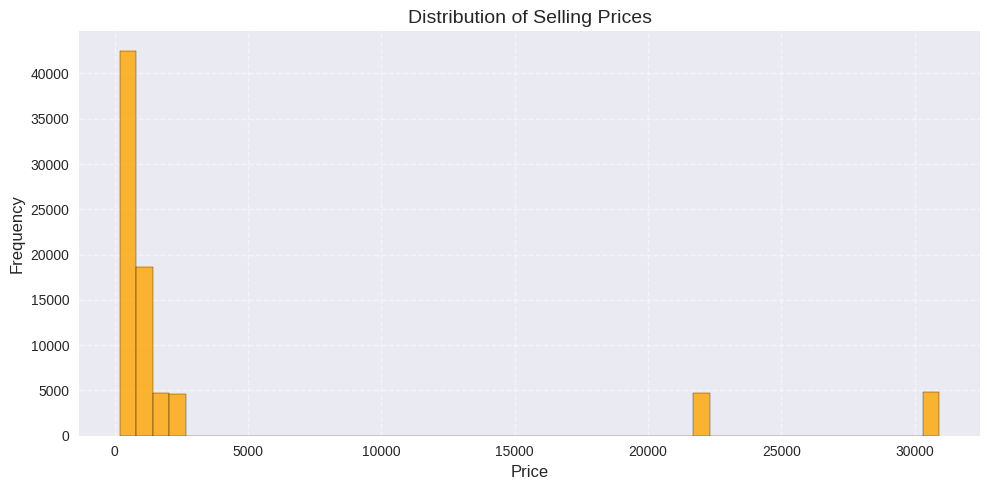


Unique values in Product_Brand: 14
+-------------+-----+
|Product_Brand|count|
+-------------+-----+
|B-3078       |18875|
|B-1880       |4846 |
|B-1517       |4803 |
|B-2679       |4752 |
|B-2755       |4742 |
+-------------+-----+
only showing top 5 rows


Unique values in Item_Category: 12
+------------------------------------+-----+
|Item_Category                       |count|
+------------------------------------+-----+
|home decor festive needs            |18787|
|clothing                            |14193|
|miss wow slim fit women s blue jeans|4846 |
|jewellery                           |4803 |
|beauty and personal care            |4745 |
+------------------------------------+-----+
only showing top 5 rows


Unique values in Subcategory_1: 14
+----------------+-----+
|Subcategory_1   |count|
+----------------+-----+
|unknown         |9588 |
|women s clothing|9466 |
|showpieces      |9351 |
|rings           |4803 |
|eye care        |4745 |
+----------------+-----+
only showing t

In [3]:
# Basic statistics
print("Training Data Shape:", (train_df.count(), len(train_df.columns)))
print("Test Data Shape:", (test_df.count(), len(test_df.columns)))

# Summary statistics for numerical columns
train_df.describe(['Item_Rating', 'Selling_Price']).show()

# Check for missing values
def check_missing_values(df):
    missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    return missing_values

print("Missing values in training data:")
check_missing_values(train_df).show()

print("Missing values in test data:")
check_missing_values(test_df).show()

# Selling Price Distribution (convert to pandas for visualization)
train_pd = train_df.select('Selling_Price').toPandas()

plt.figure(figsize=(10, 5))
plt.hist(train_pd['Selling_Price'], bins=50, alpha=0.8, color='orange', edgecolor='black')
plt.title('Distribution of Selling Prices', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Categorical columns analysis
categorical_cols = ['Product_Brand', 'Item_Category', 'Subcategory_1', 'Subcategory_2']

for col_name in categorical_cols:
    print(f"\nUnique values in {col_name}: {train_df.select(col_name).distinct().count()}")
    train_df.groupBy(col_name).count().orderBy('count', ascending=False).show(5, truncate=False)

### **SECTION 4: PREPROCESSING**

In [4]:

fill_date = '2010-01-01'
train_df = train_df.withColumn(
    "Date",
    when(col("Date").isNull(), to_date(lit(fill_date)))
    .otherwise(col("Date")))

test_df = test_df.withColumn(
    "Date",
    when(col("Date").isNull(), to_date(lit(fill_date)))
    .otherwise(col("Date")))

def process_date(df):
    return df.withColumn('Date', to_date(col('Date'), 'd/M/yyyy')) \
             .withColumn('Year', year(col('Date'))) \
             .withColumn('Month', month(col('Date'))) \
             .withColumn('Day', dayofmonth(col('Date')))

train_df = process_date(train_df)
test_df = process_date(test_df)

# First handle any null values in the data
# For numerical columns
train_df = train_df.fillna({'Item_Rating': 0.0, 'Selling_Price': 0})
test_df = test_df.fillna({'Item_Rating': 0.0})

# For categorical columns
for col_name in categorical_cols:
    train_df = train_df.fillna({col_name: "unknown"})
    test_df = test_df.fillna({col_name: "unknown"})

# Index categorical columns with handleInvalid="keep"
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in categorical_cols]

# Assemble features with explicit handleInvalid="keep"
feature_cols = ['Item_Rating', 'Year', 'Month', 'Day'] + [col+"_index" for col in categorical_cols]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="keep"  # This is the critical change
)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Create pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Fit pipeline to training data
preprocessing_model = preprocessing_pipeline.fit(train_df)

# Transform both training and test data
train_prepared = preprocessing_model.transform(train_df)
test_prepared = preprocessing_model.transform(test_df)

# Show prepared data
train_prepared.select("features", "scaledFeatures", "Selling_Price").show(5, truncate=False)

+-----------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|features                                 |scaledFeatures                                                                                                                                       |Selling_Price|
+-----------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|[4.1,2017.0,4.0,12.0,0.0,7.0,9.0,8.0]    |[4.359249915719904,661.9036343863108,0.9648105225654648,2.6030166670653774,0.0,1.8900469902808528,2.1348690670032022,1.843156053369461]              |1798         |
|[4.1,2018.0,1.0,12.0,7.0,0.0,2.0,6.0]    |[4.359249915719904,662.2317968227939,0.2412026306413662,2.6030166670653774,1.590916514806224,0.0,0.47441534822293385,1.382367

In [5]:
train_df.show()

+-------+-------------+--------------------+--------------------+--------------------+-----------+----------+-------------+----+-----+---+
|Product|Product_Brand|       Item_Category|       Subcategory_1|       Subcategory_2|Item_Rating|      Date|Selling_Price|Year|Month|Day|
+-------+-------------+--------------------+--------------------+--------------------+-----------+----------+-------------+----+-----+---+
| P-8398|       B-3078|            footwear|    women s footwear|        casual shoes|        4.1|2017-04-12|         1798|2017|    4| 12|
| P-9951|       B-2605|home decor festiv...|          showpieces|shoppingtara show...|        4.1|2018-01-12|          416|2018|    1| 12|
| P-5086|       B-1347|           computers| computer components|          processors|        4.3|2019-01-12|         2470|2019|    1| 12|
|P-10744|       B-2830|      kitchen dining|            cookware|           pots pans|        3.1|2013-01-12|          955|2013|    1| 12|
| P-8398|       B-3078|    

### **SECTION 5: MODEL IMPLEMENTATION**


=== Sample Predictions from Random Forest ===
+-----------------+
|       prediction|
+-----------------+
| 4982.80599078341|
| 8052.22804541596|
|894.3726032565679|
|           1333.5|
|2135.930584149103|
+-----------------+
only showing top 5 rows


=== Model Performance Comparison ===
                 Model  Train RMSE  Train R²  Train MAE
         Random Forest      43.635     1.000     25.100
Gradient Boosted Trees       0.789     1.000      0.381
     Linear Regression    4843.191     0.671   3604.845


<ipython-input-6-12e58f9ce5ab>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature',


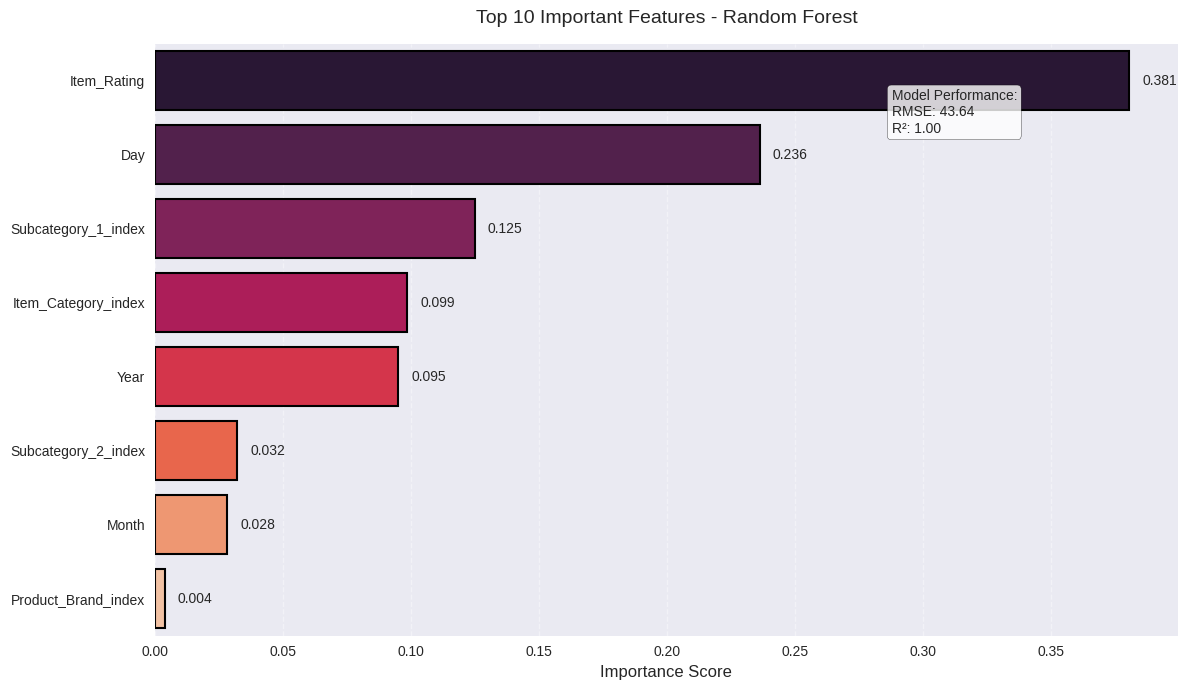

In [6]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models with display names
models = {
    "Random Forest": RandomForestRegressor(featuresCol="scaledFeatures", labelCol="Selling_Price"),
    "Gradient Boosted Trees": GBTRegressor(featuresCol="scaledFeatures", labelCol="Selling_Price"),
    "Linear Regression": LinearRegression(featuresCol="scaledFeatures", labelCol="Selling_Price")
}

# Train all models
trained_models = {}
for name, model in models.items():
    trained_models[name] = model.fit(train_prepared)

# Create evaluators
evaluator = RegressionEvaluator(labelCol="Selling_Price", predictionCol="prediction")

# Evaluate and compare models
results = []
for name, model in trained_models.items():
    # Training predictions
    train_pred = model.transform(train_prepared)

    # Test predictions
    test_pred = model.transform(test_prepared)

    # Calculate metrics
    metrics = {
        "Model": name,
        "Train RMSE": evaluator.setMetricName("rmse").evaluate(train_pred),
        "Train R²": evaluator.setMetricName("r2").evaluate(train_pred),
        "Train MAE": evaluator.setMetricName("mae").evaluate(train_pred)
    }
    results.append(metrics)

    # Show sample predictions for first model
    if name == list(models.keys())[0]:
        print(f"\n=== Sample Predictions from {name} ===")
        test_pred.select("prediction").show(5)

# Display model comparison
results_df = pd.DataFrame(results)
print("\n=== Model Performance Comparison ===")
print(results_df.to_string(index=False, float_format="%.3f"))

# Feature importance visualization for Random Forest only
rf_model = trained_models["Random Forest"]
rf_feature_importance = rf_model.featureImportances
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_feature_importance.toArray()
}).sort_values('Importance', ascending=False).head(10)  # Show top 10 features

# Enhanced visualization
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Importance', y='Feature',
                data=feature_importance_df,
                palette='rocket',      # Attractive color scheme
                edgecolor='black',     # Black borders
                linewidth=1.5,         # Border thickness
                saturation=0.9)        # Color saturation

# Add value labels
for p in ax.patches:
    ax.text(p.get_width() + 0.005,
            p.get_y() + p.get_height()/2,
            f'{p.get_width():.3f}',
            va='center',
            fontsize=10)

# Styling
plt.title('Top 10 Important Features - Random Forest', fontsize=14, pad=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True)

# Add model performance annotation
plt.annotate(f'Model Performance:\nRMSE: {results_df[results_df["Model"]=="Random Forest"]["Train RMSE"].values[0]:.2f}\nR²: {results_df[results_df["Model"]=="Random Forest"]["Train R²"].values[0]:.2f}',
             xy=(0.72, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


### **SECTION 6: HYPERPARAMETER TUNING**

In [7]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(featuresCol="scaledFeatures", labelCol="Selling_Price"),
    "GBT": GBTRegressor(featuresCol="scaledFeatures", labelCol="Selling_Price"),
    "Linear Regression": LinearRegression(featuresCol="scaledFeatures", labelCol="Selling_Price")
}

# Create evaluator
evaluator = RegressionEvaluator(labelCol="Selling_Price", predictionCol="prediction")

# Store results
results = []

# 1. Tune and evaluate Random Forest separately
print("=== Tuning Random Forest ===")
rf = models["Random Forest"]

# Parameter grid for RF
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.numTrees, [20, 50, 100])
             .addGrid(rf.maxBins, [20, 32, 45])
             .build())

# Cross-validation for RF
rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=evaluator.setMetricName("rmse"),
                          numFolds=3)

rf_model = rf_crossval.fit(train_prepared)
best_rf = rf_model.bestModel

# Evaluate RF
rf_pred = best_rf.transform(train_prepared)
rf_rmse = evaluator.setMetricName("rmse").evaluate(rf_pred)
rf_r2 = evaluator.setMetricName("r2").evaluate(rf_pred)
rf_mae = evaluator.setMetricName("mae").evaluate(rf_pred)

results.append({
    "Model": "Random Forest (Tuned)",
    "RMSE": rf_rmse,
    "R2": rf_r2,
    "MAE": rf_mae
})

# 2. Evaluate other models
for name, model in models.items():
    if name != "Random Forest":  # We already tuned RF
        print(f"\n=== Evaluating {name} ===")
        m = model.fit(train_prepared)
        pred = m.transform(train_prepared)

        results.append({
            "Model": name,
            "RMSE": evaluator.setMetricName("rmse").evaluate(pred),
            "R2": evaluator.setMetricName("r2").evaluate(pred),
            "MAE": evaluator.setMetricName("mae").evaluate(pred)
        })

# Display all results
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df.to_string(index=False))

# Identify best model
best_model = results_df.loc[results_df['RMSE'].idxmin()]
print("\n=== Best Performing Model ===")
print(f"Model: {best_model['Model']}")
print(f"RMSE: {best_model['RMSE']:.4f}")
print(f"R2: {best_model['R2']:.4f}")
print(f"MAE: {best_model['MAE']:.4f}")

# Make predictions with best model
if "Random Forest" in best_model['Model']:
    final_model = best_rf
else:
    final_model = models[best_model['Model']].fit(train_prepared)

test_predictions = final_model.transform(test_prepared)
print("\n=== Sample Test Predictions ===")
test_predictions.select("prediction").show(5)

=== Tuning Random Forest ===

=== Evaluating GBT ===

=== Evaluating Linear Regression ===

=== Model Comparison ===
                Model        RMSE       R2         MAE
Random Forest (Tuned)    2.751873 1.000000    0.946569
                  GBT    0.789070 1.000000    0.380719
    Linear Regression 4843.190756 0.670826 3604.845206

=== Best Performing Model ===
Model: GBT
RMSE: 0.7891
R2: 1.0000
MAE: 0.3807

=== Sample Test Predictions ===
+------------------+
|        prediction|
+------------------+
| 936.9604596822688|
| 473.7891339558795|
|1076.2593001381347|
|2412.1127808620367|
|2469.7750300831967|
+------------------+
only showing top 5 rows



In [ ]:
KeyError

### **SECTION 7: STREAMING DATA IMPLEMENTATION**

#### **Setting Up a Simulated Streaming Source**

In [10]:
import os
import time
import shutil
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import col, to_date, sum as spark_sum, desc
from pyspark.ml.evaluation import RegressionEvaluator

# Path to simulate streaming data ingestion
stream_path = "/content/temp_streaming_data"

# 1. Prepare streaming folder by deleting if exists and recreate
shutil.rmtree(stream_path, ignore_errors=True)
os.makedirs(stream_path, exist_ok=True)

# 2. Define schema matching train.csv structure
streaming_schema = StructType([
    StructField("Product", StringType(), True),
    StructField("Product_Brand", StringType(), True),
    StructField("Item_Category", StringType(), True),
    StructField("Subcategory_1", StringType(), True),
    StructField("Subcategory_2", StringType(), True),
    StructField("Item_Rating", DoubleType(), True),
    StructField("Date", StringType(), True),
    StructField("Selling_Price", DoubleType(), True)
])

# 3. Read stream with schema and trigger processing 1 file at a time
streaming_df = (
    spark.readStream
    .schema(streaming_schema)
    .option("maxFilesPerTrigger", 1)
    .csv(stream_path)
)

def process_streaming_batch(batch_df, batch_id):
    print(f"\n🔄 Processing batch {batch_id}...")

    # Drop header rows (if any) that appear as data (e.g. Product == "Product")
    filtered_df = batch_df.filter(col("Product") != "Product")

    if filtered_df.rdd.isEmpty():
        print(f"⚠️ Batch {batch_id} is empty after filtering headers. Skipping...")
        return

    # Convert date string to proper date type once
    df_with_date = filtered_df.withColumn("Date", to_date(col("Date"), "d/M/yyyy"))

    # Process date column/features (your custom function)
    df_processed = process_date(df_with_date)

    # Fill nulls for ratings and categorical columns
    df_filled = df_processed.fillna({'Item_Rating': 0.0})
    for col_name in categorical_cols:
        df_filled = df_filled.fillna({col_name: "unknown"})

    # *** LIVE ANALYSIS: Aggregate total sales by Item_Category ***
    category_sales = (
        df_filled
        .groupBy("Item_Category")
        .agg(spark_sum("Selling_Price").alias("Total_Sales"))
        .orderBy(desc("Total_Sales"))
    )

    print(f"📊 Top product categories by sales in Batch {batch_id}:")
    category_sales.show(5, truncate=False)  # show top 5 categories

    # Apply preprocessing pipeline (your existing fitted model)
    prepared_df = preprocessing_model.transform(df_filled)

    # Predict with your trained random forest model
    predictions = rf_model.transform(prepared_df)

    # Show sample results
    predictions.select(
        "Product", "Product_Brand", "Item_Category",
        "Item_Rating", "Date", "Selling_Price", "prediction"
    ).show(5, truncate=False)

    # Evaluate RMSE if Selling_Price column is present and non-null
    if "Selling_Price" in predictions.columns and predictions.filter(col("Selling_Price").isNotNull()).count() > 0:
        evaluator = RegressionEvaluator(labelCol="Selling_Price", predictionCol="prediction", metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        print(f"✅ RMSE for Batch {batch_id}: {rmse:.2f}")
    else:
        print(f"⚠️ Selling_Price missing or null in batch {batch_id}, skipping RMSE evaluation.")

# 4. Start streaming query
query = (
    streaming_df.writeStream
    .foreachBatch(process_streaming_batch)
    .outputMode("append")
    .start()
)

# 5. Simulate streaming data by writing batches of train.csv as CSV files
train_data = pd.read_csv("/content/train.csv")
batch_size = 1000

for i in range(0, len(train_data), batch_size):
    batch = train_data.iloc[i:i+batch_size]
    batch.to_csv(f"{stream_path}/batch_{i//batch_size}.csv", index=False)
    time.sleep(2)  # Delay between batches to simulate streaming

# 6. Wait enough time for stream processing before stopping query
time.sleep(30)
query.stop()



🔄 Processing batch 0...
📊 Top product categories by sales in Batch 0:
+------------------------+-----------+
|Item_Category           |Total_Sales|
+------------------------+-----------+
|jewellery               |1484064.0  |
|home decor festive needs|1206802.0  |
|computers               |123500.0   |
|clothing                |116416.0   |
|footwear                |97092.0    |
+------------------------+-----------+
only showing top 5 rows

+-------+-------------+------------------------+-----------+----------+-------------+----------+
|Product|Product_Brand|Item_Category           |Item_Rating|Date      |Selling_Price|prediction|
+-------+-------------+------------------------+-----------+----------+-------------+----------+
|P-8398 |B-3078       |footwear                |4.1        |2017-04-12|1798.0       |1798.0    |
|P-9951 |B-2605       |home decor festive needs|4.1        |2018-01-12|416.0        |416.0     |
|P-5086 |B-1347       |computers               |4.3        |2019-01-

KeyboardInterrupt: 